# Societe Generale Complaint Tracker

In [1]:
import pandas as panda

from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, \
    confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

from matplotlib import pyplot as plot
import seaborn as sns


from numpy import bincount, linspace, mean, std, arange, squeeze

import itertools, time, datetime

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [26]:
test_data_path ='dataset/test.csv'
train_data_path = 'dataset/train.csv'
sample_submission_path = 'dataset/sample_submission.csv'


In [46]:
train_data = panda.read_csv(train_data_path)

In [4]:
train_data_shape = train_data.shape
train_data_columns = train_data.columns.tolist()

In [5]:
train_data_columns

['Complaint-ID',
 'Date-received',
 'Transaction-Type',
 'Complaint-reason',
 'Company-response',
 'Date-sent-to-company',
 'Complaint-Status',
 'Consumer-disputes',
 'Consumer-complaint-summary']

In [6]:
# converting all columns to lower case for ease of typing

train_data.columns = [x.lower().strip() for x in train_data.columns.tolist()]

train_data.columns.tolist()

['complaint-id',
 'date-received',
 'transaction-type',
 'complaint-reason',
 'company-response',
 'date-sent-to-company',
 'complaint-status',
 'consumer-disputes',
 'consumer-complaint-summary']

In [7]:
target_column = 'complaint-status'

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43266 entries, 0 to 43265
Data columns (total 9 columns):
complaint-id                  43266 non-null object
date-received                 43266 non-null object
transaction-type              43266 non-null object
complaint-reason              43266 non-null object
company-response              20760 non-null object
date-sent-to-company          43266 non-null object
complaint-status              43266 non-null object
consumer-disputes             35568 non-null object
consumer-complaint-summary    43266 non-null object
dtypes: object(9)
memory usage: 3.0+ MB


In [9]:
train_data.describe(include='all')

,complaint-id,date-received,transaction-type,complaint-reason,company-response,date-sent-to-company,complaint-status,consumer-disputes,consumer-complaint-summary
count,43266,43266,43266,43266,20760,43266,43266,35568,43266
unique,43266,920,18,150,10,930,5,2,43022
top,Tr-18515,1/19/2017,Debt collection,Incorrect information on credit report,Company has responded to the consumer and the ...,1/19/2017,Closed with explanation,No,I am filing this complaint because Experian ha...
freq,1,226,10422,4466,10928,182,34300,27663,13


### lets work on the date columns first. 

##### Date Received

<li> Check for empty values </li>
<li> Convert into days passed since today </li> <br>

In [10]:
train_data[['date-received']].isnull().sum()

date-received    0
dtype: int64

In [11]:
train_data['date-received'].value_counts()

1/19/2017     226
1/20/2017     175
4/26/2017     133
4/25/2017     125
9/8/2017      125
9/9/2017      113
1/24/2017     111
1/23/2017     110
7/18/2017     108
5/9/2017      106
5/17/2017     101
9/20/2016     100
1/25/2017     100
7/12/2017      97
5/23/2017      95
6/6/2017       95
2/15/2017      94
5/10/2017      94
7/17/2017      93
5/2/2017       91
1/26/2017      90
9/28/2016      90
5/16/2017      90
7/27/2017      89
4/24/2017      89
7/7/2017       89
4/28/2017      89
3/29/2017      89
8/4/2017       89
7/13/2017      89
             ... 
8/23/2017      10
9/2/2017       10
5/10/2015      10
8/6/2017       10
6/21/2015       9
8/25/2017       9
1/3/2016        9
9/4/2016        9
12/25/2016      8
9/11/2017       8
9/12/2017       8
9/24/2017       7
12/25/2015      7
11/3/2017       6
8/26/2017       6
9/4/2017        6
9/10/2017       5
9/3/2017        5
9/25/2017       5
9/20/2017       4
9/29/2017       4
9/19/2017       4
9/16/2017       3
8/27/2017       2
8/29/2017 

In [33]:
from dateutil import relativedelta


def get_days_passed( given):
    
    current = datetime.datetime.now()
    given = datetime.datetime.strptime(given, '%m/%d/%Y')
    
    return (current-given).days

In [13]:
train_data['days_passed_since_complaint_received'] = train_data['date-received'].apply(lambda x : get_days_passed(x))

In [14]:

##lets compare the first 10 rows to check
train_data[['date-received', 'days_passed_since_complaint_received']].head(10)

,date-received,days_passed_since_complaint_received
0,11/11/2015,1154
1,7/7/2015,1281
2,5/7/2015,1342
3,11/12/2016,787
4,9/29/2016,831
5,8/2/2016,889
6,3/26/2017,653
7,10/15/2016,815
8,1/18/2016,1086
9,8/17/2015,1240


In [15]:
train_data[['date-received', 'days_passed_since_complaint_received']].tail(10)

##seems about right.. the months 

,date-received,days_passed_since_complaint_received
43256,9/28/2015,1198
43257,4/28/2015,1351
43258,4/25/2017,623
43259,11/23/2016,776
43260,5/10/2017,608
43261,7/28/2017,529
43262,1/23/2017,715
43263,3/9/2017,670
43264,7/15/2017,542
43265,6/8/2017,579


##### Date Sent to Company

<li> Check for empty values </li>
<li> Convert into days passed since today </li> <br>

In [16]:
train_data['date-sent-to-company'].isnull().sum()

0

In [17]:
train_data['date-sent-to-company'].value_counts()

1/19/2017     182
1/20/2017     156
4/26/2017     124
5/17/2017     119
5/3/2017      119
4/25/2017     116
9/8/2017      115
9/9/2017      113
1/25/2017     113
1/24/2017     112
11/13/2015    110
7/18/2017     109
1/18/2017     109
9/20/2016     108
2/15/2017     106
7/12/2017     104
4/28/2017     103
7/17/2017     102
6/12/2017     102
6/6/2017      101
1/27/2017     101
5/10/2017     101
5/23/2017     100
3/22/2017      99
7/7/2017       99
6/21/2017      97
1/23/2017      97
5/4/2017       97
3/29/2017      97
5/31/2017      96
             ... 
9/24/2017       6
9/19/2017       6
12/25/2015      6
5/17/2015       6
8/29/2017       6
6/14/2015       6
8/26/2017       6
9/10/2017       5
9/25/2017       5
6/21/2015       5
5/10/2015       5
9/4/2017        5
9/13/2017       5
9/29/2017       4
9/20/2017       4
9/16/2017       3
9/14/2017       3
10/11/2017      2
8/27/2017       2
9/28/2017       2
9/21/2017       2
11/2/2017       2
9/22/2017       2
10/13/2017      1
10/4/2017 

In [18]:
train_data['days_since_complaint_sent_to_company'] = train_data['date-sent-to-company'].apply(lambda x: get_days_passed(x))

In [19]:
train_data.head()

,complaint-id,date-received,transaction-type,complaint-reason,company-response,date-sent-to-company,complaint-status,consumer-disputes,consumer-complaint-summary,days_passed_since_complaint_received,days_since_complaint_sent_to_company
0,Tr-1,11/11/2015,Mortgage,"Loan servicing, payments, escrow account",NaN,11/11/2015,Closed with explanation,Yes,"Seterus, Inc a déposé un faux rapport auprès d...",1154,1154
1,Tr-2,7/7/2015,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,7/7/2015,Closed with non-monetary relief,No,XX / XX / XXXX La requête en faillite n ° XXXX...,1281,1281
2,Tr-3,5/7/2015,Bank account or service,Using a debit or ATM card,NaN,5/7/2015,Closed with explanation,No,"El XXXX / XXXX / 15, estaba preparando el vuel...",1342,1342
3,Tr-4,11/12/2016,Debt collection,Cont'd attempts collect debt not owed,Company believes it acted appropriately as aut...,11/12/2016,Closed with explanation,No,"The loan was paid in XXXX XXXX. In XXXX, 4 yea...",787,787
4,Tr-5,9/29/2016,Credit card,Payoff process,Company has responded to the consumer and the ...,9/29/2016,Closed with explanation,No,J'ai obtenu un compte de crédit de soins pour ...,831,831


In [20]:
## lets check for complaints where days when complaint was received and complaint was sent to company was different

train_data[train_data['days_passed_since_complaint_received']!=train_data['days_since_complaint_sent_to_company']]

,complaint-id,date-received,transaction-type,complaint-reason,company-response,date-sent-to-company,complaint-status,consumer-disputes,consumer-complaint-summary,days_passed_since_complaint_received,days_since_complaint_sent_to_company
5,Tr-6,8/2/2016,Mortgage,"Loan modification,collection,foreclosure",NaN,8/3/2016,Closed with explanation,Yes,The owner of my original mortgage filed for ba...,889,888
10,Tr-11,1/10/2016,Mortgage,"Loan servicing, payments, escrow account",NaN,1/15/2016,Closed with explanation,No,"My mortgage provider, United Wholesale Mortgag...",1094,1089
19,Tr-20,8/31/2016,Debt collection,Cont'd attempts collect debt not owed,NaN,9/7/2016,Closed with explanation,No,"Cuando disputé con las agencias de crédito, so...",860,853
31,Tr-32,5/26/2015,Mortgage,Settlement process and costs,Company chooses not to provide a public response,5/29/2015,Closed with explanation,Yes,We request a simplified refinancing XXXX XXXX ...,1323,1320
33,Tr-34,3/2/2017,Student loan,Dealing with my lender or servicer,NaN,3/6/2017,Closed with explanation,No,I reviewed my credit report and noticed 3 late...,677,673
34,Tr-35,8/8/2016,Debt collection,Cont'd attempts collect debt not owed,NaN,8/10/2016,Closed with explanation,No,J'ai déposé un différend avec XXXX concernant ...,883,881
37,Tr-38,11/21/2015,Debt collection,Cont'd attempts collect debt not owed,NaN,12/29/2015,Untimely response,No,My husband and I had a credit card debt and th...,1144,1106
45,Tr-46,10/28/2015,Payday loan,Charged fees or interest I didn't expect,NaN,10/30/2015,Closed with explanation,No,He tenido un préstamo con Rise Credit por más ...,1168,1166
46,Tr-47,4/16/2016,Student loan,Dealing with my lender or servicer,NaN,4/20/2016,Closed with explanation,No,"XX / XX / XXXX, I submitted my tax documents f...",997,993
51,Tr-52,7/26/2015,Mortgage,"Loan servicing, payments, escrow account",Company believes it acted appropriately as aut...,7/29/2015,Closed with non-monetary relief,No,"Here we go again. Obviously, Greetree does not...",1262,1259


There is a pretty sizeable chunk where complaints received and complaints sent were different
<br><br>
Now that we have dealt with date columns, we will deal with the other categorical columns. since most are categorical.

<br>
We are going to ignore the column consumer-complaint-summary for now. Lets check our scores without it

##### Transaction Type

<li> Check for empty values </li>
<li> Convert to numerical values </li>

In [21]:
train_data['transaction-type'].value_counts()

Debt collection                                                                 10422
Mortgage                                                                         7950
Credit reporting                                                                 6706
Credit card                                                                      4119
Bank account or service                                                          3264
Credit reporting, credit repair services, or other personal consumer reports     3169
Student loan                                                                     2874
Consumer Loan                                                                    2033
Credit card or prepaid card                                                       719
Checking or savings account                                                       496
Payday loan                                                                       363
Money transfers                                       

In [22]:
train_data['transaction-type'].isnull().sum()

0

In [23]:
le = LabelEncoder().fit(train_data['transaction-type'].values)

print(le.classes_)

transformed_transaction_types = le.transform(train_data['transaction-type'].values)


['Bank account or service' 'Checking or savings account' 'Consumer Loan'
 'Credit card' 'Credit card or prepaid card' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Money transfer, virtual currency, or money service'
 'Money transfers' 'Mortgage' 'Other financial service' 'Payday loan'
 'Payday loan, title loan, or personal loan' 'Prepaid card' 'Student loan'
 'Vehicle loan or lease' 'Virtual currency']


In [24]:
transformed = OneHotEncoder().fit_transform(transformed_transaction_types[:,np.newaxis])

print(transformed.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [25]:
tt = panda.DataFrame(transformed.toarray())
tt.columns = le.classes_
tt

,Bank account or service,Checking or savings account,Consumer Loan,Credit card,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Money transfers,Mortgage,Other financial service,Payday loan,"Payday loan, title loan, or personal loan",Prepaid card,Student loan,Vehicle loan or lease,Virtual currency
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
train_data_transaction_type_encoded = panda.concat([train_data,tt], axis =1)

In [27]:
## in order to not run out of memory we will delete the tt object

del tt
del le

In [28]:
train_data_transaction_type_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43266 entries, 0 to 43265
Data columns (total 29 columns):
complaint-id                                                                    43266 non-null object
date-received                                                                   43266 non-null object
transaction-type                                                                43266 non-null object
complaint-reason                                                                43266 non-null object
company-response                                                                20760 non-null object
date-sent-to-company                                                            43266 non-null object
complaint-status                                                                43266 non-null object
consumer-disputes                                                               35568 non-null object
consumer-complaint-summary                                                 

##### Complaint Reason

<li> Check for empty values </li>
<li> Convert to numerical value </li>

In [29]:
train_data_transaction_type_encoded['complaint-reason'].isnull().sum()

0

In [30]:
train_data_transaction_type_encoded['complaint-reason'].value_counts()
## geez total to 150 diff values

Incorrect information on credit report                                              4466
Cont'd attempts collect debt not owed                                               3755
Loan servicing, payments, escrow account                                            3216
Loan modification,collection,foreclosure                                            2385
Dealing with my lender or servicer                                                  1683
Disclosure verification of debt                                                     1625
Incorrect information on your report                                                1587
Communication tactics                                                               1487
Account opening, closing, or management                                             1423
Credit reporting company's investigation                                            1249
Managing the loan or lease                                                          1027
False statements or r

#### IMPORTANT:We will attempt to bin these values later.. since business acumen would be required in order to do so. By binning i mean, values like managing line of credit, incorrect line of credit, getting line of credit can be marked as LOC

In [31]:
le = LabelEncoder().fit(train_data_transaction_type_encoded['complaint-reason'].values)
transformed_values  = le.transform(train_data_transaction_type_encoded['complaint-reason'].values)

transformed = OneHotEncoder().fit_transform(transformed_values[:,np.newaxis])

tt = panda.DataFrame(transformed.toarray())
tt.columns = le.classes_

tt

,APR or interest rate,"Account opening, closing, or management",Account terms and changes,Adding money,Advertising,Advertising and marketing,"Advertising and marketing, including promotional offers","Advertising, marketing or disclosures",Application processing delay,"Application, originator, mortgage broker",...,Unauthorized transactions or other transaction problem,Unauthorized transactions/trans. issues,Unexpected or other fees,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Vehicle was repossessed or sold the vehicle,"Was approved for a loan, but didn't receive the money",Written notification about debt,Wrong amount charged or received
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
train_data_two_encoded = panda.concat([train_data_transaction_type_encoded,tt],axis = 1)

train_data_two_encoded

,complaint-id,date-received,transaction-type,complaint-reason,company-response,date-sent-to-company,complaint-status,consumer-disputes,consumer-complaint-summary,days_passed_since_complaint_received,...,Unauthorized transactions or other transaction problem,Unauthorized transactions/trans. issues,Unexpected or other fees,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Vehicle was repossessed or sold the vehicle,"Was approved for a loan, but didn't receive the money",Written notification about debt,Wrong amount charged or received
0,Tr-1,11/11/2015,Mortgage,"Loan servicing, payments, escrow account",NaN,11/11/2015,Closed with explanation,Yes,"Seterus, Inc a déposé un faux rapport auprès d...",1154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Tr-2,7/7/2015,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,7/7/2015,Closed with non-monetary relief,No,XX / XX / XXXX La requête en faillite n ° XXXX...,1281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Tr-3,5/7/2015,Bank account or service,Using a debit or ATM card,NaN,5/7/2015,Closed with explanation,No,"El XXXX / XXXX / 15, estaba preparando el vuel...",1342,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Tr-4,11/12/2016,Debt collection,Cont'd attempts collect debt not owed,Company believes it acted appropriately as aut...,11/12/2016,Closed with explanation,No,"The loan was paid in XXXX XXXX. In XXXX, 4 yea...",787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tr-5,9/29/2016,Credit card,Payoff process,Company has responded to the consumer and the ...,9/29/2016,Closed with explanation,No,J'ai obtenu un compte de crédit de soins pour ...,831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Tr-6,8/2/2016,Mortgage,"Loan modification,collection,foreclosure",NaN,8/3/2016,Closed with explanation,Yes,The owner of my original mortgage filed for ba...,889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Tr-7,3/26/2017,Credit reporting,Incorrect information on credit report,NaN,3/26/2017,Closed with explanation,No,J'ai été victime d'une fraude d'identité et j'...,653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Tr-8,10/15/2016,Bank account or service,Problems caused by my funds being low,Company has responded to the consumer and the ...,10/15/2016,Closed with explanation,No,"Je suis en train de faire faillite et, par con...",815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Tr-9,1/18/2016,Debt collection,Cont'd attempts collect debt not owed,NaN,1/18/2016,Closed with explanation,Yes,Una agencia de cobranza me hizo adulterar de q...,1086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Tr-10,8/17/2015,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,8/17/2015,Closed with non-monetary relief,No,"Le XXXX / XXXX / 2015, j'ai reçu une réponse d...",1240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
del tt
del le

##### Company Response

<li> Check for empty values </li>
<li> Convert to numerical value </li>

In [34]:
train_data_two_encoded['company-response'].isnull().sum()

## there are quite a few null values.. we will see what we can do about it.
## check the complaint status for the ones which has nan in company response
## if status is same throughout-- we can replace nan with some made up status
## else we will replace with the most appearing response

22506

In [35]:
train_data_two_encoded['company-response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            10928
Company chooses not to provide a public response                                                                            4322
Company believes it acted appropriately as authorized by contract or law                                                    3811
Company believes the complaint is the result of a misunderstanding                                                           387
Company disputes the facts presented in the complaint                                                                        379
Company believes complaint is the result of an isolated error                                                                302
Company believes complaint caused principally by actions of third party outside the control or direction of the company      300
Company can't verify or dispute the facts in the complaint                                       

In [36]:
empty_response = train_data_two_encoded[train_data_two_encoded['company-response'].isnull()][['company-response','complaint-status']]

empty_response

,company-response,complaint-status
0,NaN,Closed with explanation
2,NaN,Closed with explanation
5,NaN,Closed with explanation
6,NaN,Closed with explanation
8,NaN,Closed with explanation
10,NaN,Closed with explanation
11,NaN,Closed with explanation
14,NaN,Closed
17,NaN,Closed with explanation
19,NaN,Closed with explanation


In [37]:
empty_response['complaint-status'].value_counts()

Closed with explanation            18696
Closed with non-monetary relief     1863
Closed with monetary relief         1171
Closed                               455
Untimely response                    321
Name: complaint-status, dtype: int64

#### Since most status of the are closed..we will decide on categorical variable to replace NaN values for company-response. Lets get the most appearing company response for complaint status similar to the one above (except the NaN ones)

In [38]:
a = empty_response['complaint-status'].value_counts()

t =train_data_two_encoded[train_data_two_encoded['complaint-status'].isin(a.index.tolist())][['company-response']]

t['company-response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            10928
Company chooses not to provide a public response                                                                            4322
Company believes it acted appropriately as authorized by contract or law                                                    3811
Company believes the complaint is the result of a misunderstanding                                                           387
Company disputes the facts presented in the complaint                                                                        379
Company believes complaint is the result of an isolated error                                                                302
Company believes complaint caused principally by actions of third party outside the control or direction of the company      300
Company can't verify or dispute the facts in the complaint                                       

In [39]:
most_appearing = t['company-response'].value_counts().index.tolist()[0]

In [40]:
del t, empty_response, a


<br> We will replace the empty value with the most appearing value for the column company-response

In [41]:
train_data_two_encoded['company-response'].fillna(value = most_appearing, inplace=True)

train_data_two_encoded['company-response'].isnull().sum()

0

##### Consumer disputes

<li> Check for empty values </li>
<li> Convert to numerical value </li>

In [42]:

train_data_two_encoded['consumer-disputes'].isnull().sum()
## dere are close to 8k empty values..for now we will replace it will most appearing value

7698

In [43]:
train_data_two_encoded['consumer-disputes'].value_counts()

No     27663
Yes     7905
Name: consumer-disputes, dtype: int64

In [44]:
most_appearing = train_data_two_encoded['consumer-disputes'].value_counts().idxmax(axis=1)
most_appearing

'No'

In [45]:
train_data_two_encoded['consumer-disputes'].fillna(value = most_appearing, inplace = True)

train_data_two_encoded['consumer-disputes'].isnull().sum()

0

In [46]:
train_data_two_encoded['encoded_consumer_disputes']= train_data_two_encoded['consumer-disputes'].apply(lambda x: 1 if x=='Yes' else 0)

In [47]:
train_data_two_encoded['encoded_consumer_disputes'].value_counts()

0    35361
1     7905
Name: encoded_consumer_disputes, dtype: int64

### At this point we are done with our feature engineering/data wrangling except for the complaint-summary column which we will perform later

### Its time for us to check the target column and perform some analysis on the samea

In [48]:
train_data_two_encoded['complaint-status'].isnull().sum()

## all our target columns are present. lets check the discreet values

0

In [49]:
train_data_two_encoded['complaint-status'].value_counts()

## as is clear our datasets are hugely imbalanced. we will use f1 scores to check for accuracy. and this is multiclass clssification

Closed with explanation            34300
Closed with non-monetary relief     5018
Closed with monetary relief         2818
Closed                               809
Untimely response                    321
Name: complaint-status, dtype: int64

In [50]:
#lets apply encoding on our target columns

target_dict = {
    
    'Closed with explanation':1,
    'Closed with non-monetary relief':2,
    'Closed with monetary relief':3,
    'Closed':4,
    'Untimely response':5
    
}
train_data_two_encoded['y'] = train_data_two_encoded['complaint-status'].apply(lambda x: target_dict.get(x))

In [51]:
train_data_two_encoded['y'].value_counts()

1    34300
2     5018
3     2818
4      809
5      321
Name: y, dtype: int64

In [52]:
#lets prepare our x and y values

train_data_two_encoded.columns.tolist()

['complaint-id',
 'date-received',
 'transaction-type',
 'complaint-reason',
 'company-response',
 'date-sent-to-company',
 'complaint-status',
 'consumer-disputes',
 'consumer-complaint-summary',
 'days_passed_since_complaint_received',
 'days_since_complaint_sent_to_company',
 'Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit card or prepaid card',
 'Credit reporting',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan',
 'Payday loan, title loan, or personal loan',
 'Prepaid card',
 'Student loan',
 'Vehicle loan or lease',
 'Virtual currency',
 'APR or interest rate',
 'Account opening, closing, or management',
 'Account terms and changes',
 'Adding money',
 'Advertising',
 'Advertising and marketing',
 'Advertising and marketing, including promotional o

In [53]:
train_data_two_encoded.shape[0] == train_data.shape[0]

#we will check if our data wrangling hasnt introduced any new rows

True

train_data_two_encoded.to_csv('dataset/encoded_train.csv')

In [2]:
train_data_two_encoded = panda.read_csv('dataset/encoded_train.csv')

In [3]:
## lets prepare our x data set values

columns_not_required = ['complaint-id',\
 'date-received',\
 'transaction-type',\
 'complaint-reason',\
 'company-response',\
 'date-sent-to-company',\
 'complaint-status',\
 'consumer-disputes',\
 'consumer-complaint-summary']


x = train_data_two_encoded[[i for i in train_data_two_encoded.columns.tolist() if i not in columns_not_required]]

x.head()

,Unnamed: 0,days_passed_since_complaint_received,days_since_complaint_sent_to_company,Bank account or service,Checking or savings account,Consumer Loan,Credit card,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",...,Unexpected or other fees,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Vehicle was repossessed or sold the vehicle,"Was approved for a loan, but didn't receive the money",Written notification about debt,Wrong amount charged or received,encoded_consumer_disputes,y
0,0,1154,1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,1,1281,1281,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
2,2,1342,1342,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1
3,3,787,787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,4,831,831,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [4]:
y = train_data_two_encoded[['y']]
y.head()

,y
0,1
1,2
2,1
3,1
4,1


In [5]:
## its time to run my pipeline and classification models



## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(random_state = 1),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
    
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [1,5,8,10], 'perceptron__eta0': [0.5,.4, .2, .1]},
            {'logisticregression__C':[100,200,300,50,20,600]},
            {'decisiontreeclassifier__max_depth':[6,7,8,9,10,11],'decisiontreeclassifier__criterion':['gini',]},
            {'randomforestclassifier__n_estimators':[1,2,3,5,6],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,7,8]},
    
]

In [6]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [16]:

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
#     print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
        
    with predict_proba_timer:
        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            y_probability = gridsearch.predict_proba(x_test)
#             false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:,1])
#             response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
#             response['roc_curve'] = (false_positive_rate, true_positive_rate)
    
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = None
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['best_estimator'] = gridsearch.best_estimator_
    
    
    return response

In [8]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)

In [9]:
print("label counts in y train %s" %_y_train['y'].value_counts())
print("label counts in y test %s" %_y_test['y'].value_counts())

label counts in y train 1    24010
2     3512
3     1973
4      566
5      225
Name: y, dtype: int64
label counts in y test 1    10290
2     1506
3      845
4      243
5       96
Name: y, dtype: int64


Grid Search Best parameters  {'perceptron__eta0': 0.5, 'perceptron__max_iter': 10}
Grid Search Best score  0.9377550283867416
Code block 'training' took(HH:MM:SS): 0:03:44.594185
Code block 'testing' took(HH:MM:SS): 0:00:00.089530
F1 score 0.9421097161438318
Classification report  
              precision    recall  f1-score   support

          1       0.99      0.99      0.99     10290
          2       0.80      0.86      0.83      1506
          3       0.74      0.83      0.78       845
          4       0.43      0.17      0.25       243
          5       0.85      0.64      0.73        96

avg / total       0.94      0.94      0.94     12980



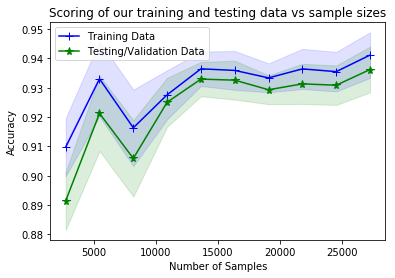

Code block 'learning_curve' took(HH:MM:SS): 0:01:39.527379
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000027
Grid Search Best parameters  {'logisticregression__C': 300}
Grid Search Best score  0.9601531171171778
Code block 'training' took(HH:MM:SS): 0:52:17.378888
Code block 'testing' took(HH:MM:SS): 0:00:00.074051
F1 score 0.9628366562556984
Classification report  
              precision    recall  f1-score   support

          1       1.00      1.00      1.00     10290
          2       0.88      0.87      0.88      1506
          3       0.76      0.92      0.83       845
          4       0.89      0.26      0.40       243
          5       0.92      1.00      0.96        96

avg / total       0.97      0.97      0.96     12980



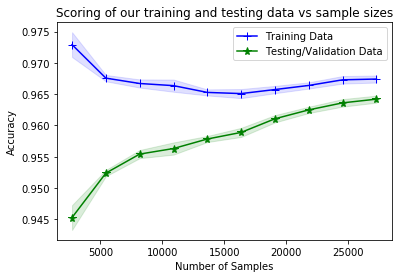

Code block 'learning_curve' took(HH:MM:SS): 0:47:06.915236
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.115759
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  1.0
Code block 'training' took(HH:MM:SS): 0:00:48.165610
Code block 'testing' took(HH:MM:SS): 0:00:00.089326
F1 score 1.0
Classification report  
              precision    recall  f1-score   support

          1       1.00      1.00      1.00     10290
          2       1.00      1.00      1.00      1506
          3       1.00      1.00      1.00       845
          4       1.00      1.00      1.00       243
          5       1.00      1.00      1.00        96

avg / total       1.00      1.00      1.00     12980



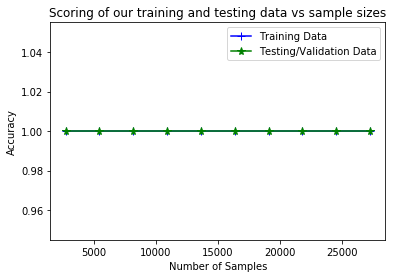

Code block 'learning_curve' took(HH:MM:SS): 0:00:45.452766
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.093220
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 6}
Grid Search Best score  0.9826315396554384
Code block 'training' took(HH:MM:SS): 0:00:46.314886
Code block 'testing' took(HH:MM:SS): 0:00:00.113753
F1 score 0.9919960504425799
Classification report  
              precision    recall  f1-score   support

          1       1.00      1.00      1.00     10290
          2       0.98      0.99      0.99      1506
          3       0.95      0.97      0.96       845
          4       0.92      0.84      0.88       243
          5       0.97      0.72      0.83        96

avg / total       0.99      0.99      0.99     12980



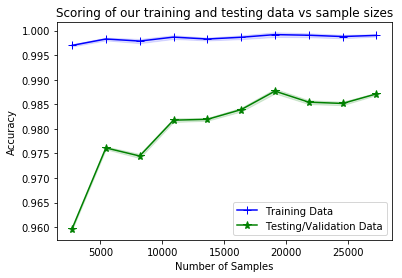

Code block 'learning_curve' took(HH:MM:SS): 0:01:01.024280
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.118351
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 4}
Grid Search Best score  0.974037039224653
Code block 'training' took(HH:MM:SS): 2:15:47.588427
Code block 'testing' took(HH:MM:SS): 0:01:14.145504
F1 score 0.9808686148915441
Classification report  
              precision    recall  f1-score   support

          1       0.99      1.00      0.99     10290
          2       0.96      0.93      0.95      1506
          3       0.97      0.90      0.93       845
          4       0.89      0.92      0.90       243
          5       0.98      0.64      0.77        96

avg / total       0.98      0.98      0.98     12980



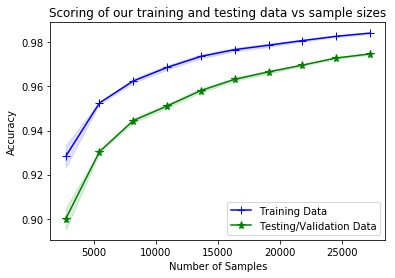

Code block 'learning_curve' took(HH:MM:SS): 1:48:43.205665
Code block 'predict_proba' took(HH:MM:SS): 0:01:13.853893
Code block 'overalltime' took(HH:MM:SS): 5:55:10.721653
21310721.65282749


In [10]:
timer = CodeTimer(name='overalltime')
model_metrics = {}

with timer:
    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])

        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 12)
        result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid , cv = cv,score = 'f1_weighted')

        _y_prediction = result['_y_prediction']

        _matrix = confusion_matrix(y_true = _y_test ,y_pred = _y_prediction, labels = _y_test['y'].values)

        model_metrics[model_name] = {}
        model_metrics[model_name]['confusion_matrix'] = _matrix
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
#         model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
        model_metrics[model_name]['f1_score'] = result['f1_score']
#         model_metrics[model_name]['roc_auc_score'] = result['roc_auc_score']
#         model_metrics[model_name]['roc_curve'] = result['roc_curve']
#         model_metrics[model_name]['best_estimator'] = result['best_estimator']
        
        
print(timer.took)


#### There are some observations we can make: 

#### 1. DecisionTreeClassifier gives perfect predictions after round 5000. And we have similar scores for testing and training data , suggesting less variations/overfitting

#### 2. Kneighbor classifiers provides us with 98% f1 score, pretty consistent across each target variable. 

#### 3. RandomForest classifier does have a better f1 score across targets, however there is a huge variation between training and testing data values, indicating variation/overfiting


#### We will use both these classifiers to make a prediction on the train set

In [13]:
model_estimates = panda.DataFrame(model_metrics).transpose()

model_estimates

,confusion_matrix,f1_score,learning_curve_time,testing_time,training_time
perceptron,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.94211,99527.4,89.5301,224594
logisticregression,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.962837,2.82692e+06,74.0506,3.13738e+06
decisiontreeclassifier,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,45452.8,89.3264,48165.6
randomforestclassifier,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.991996,61024.3,113.753,46314.9
kneighborsclassifier,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.980869,6.52321e+06,74145.5,8.14759e+06


In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

                                                         confusion_matrix  \
perceptron              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
logisticregression      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
decisiontreeclassifier  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
randomforestclassifier  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
kneighborsclassifier    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                        f1_score  learning_curve_time  testing_time  \
perceptron              0.942110             0.008348      0.000209   
logisticregression      0.962837             0.429387      0.000000   
decisiontreeclassifier  1.000000             0.000000      0.000206   
randomforestclassifier  0.991996             0.002404      0.000536   
kneighborsclassifier    0.980869             1.000000      1.000000   

                        training_time  
perceptron                   0.022006  
logisticregression           0

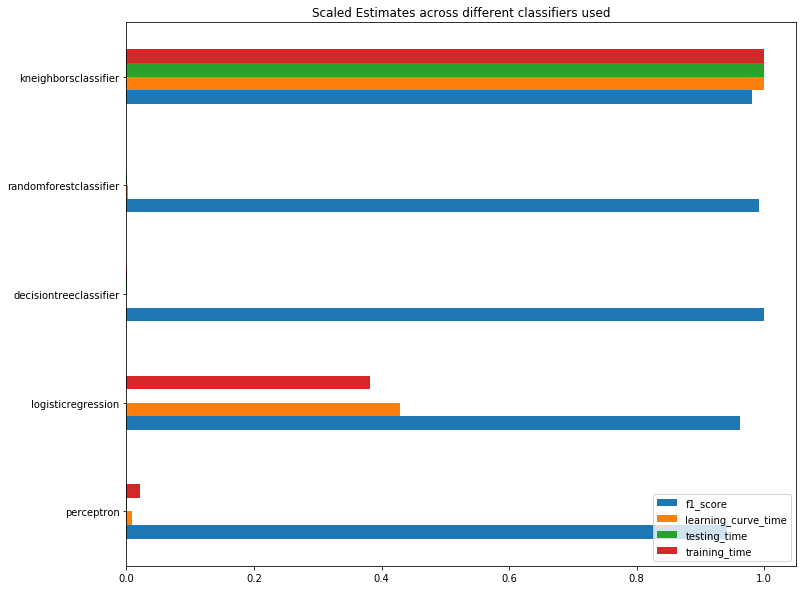

In [15]:

model_estimates['learning_curve_time'] = model_estimates['learning_curve_time'].astype('float64')
model_estimates['testing_time'] = model_estimates['testing_time'].astype('float64')
model_estimates['training_time'] = model_estimates['training_time'].astype('float64')
model_estimates['f1_score'] = model_estimates['f1_score'].astype('float64')
# model_estimates['roc_auc_score'] = model_estimates['roc_auc_score'].astype('float64')

#scaling time parameters between 0 and 1
model_estimates['learning_curve_time'] = (model_estimates['learning_curve_time']- model_estimates['learning_curve_time'].min())/(model_estimates['learning_curve_time'].max()- model_estimates['learning_curve_time'].min())
model_estimates['testing_time'] = (model_estimates['testing_time']- model_estimates['testing_time'].min())/(model_estimates['testing_time'].max()- model_estimates['testing_time'].min())
model_estimates['training_time'] = (model_estimates['training_time']- model_estimates['training_time'].min())/(model_estimates['training_time'].max()- model_estimates['training_time'].min())

print(model_estimates)
model_estimates.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

In [18]:
## we have two models we will like to use in order to make our prediction - decisiontree and randomforest

## two changes we will make, we will not perform hyperparamter tuning anymore. we already know which paramters work best

## we will return the best estimator in the returning dictionary



## we will add more classifiers in round2
classifiers = [
    DecisionTreeClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
]


classifier_names = [
            'decisiontreeclassifier',
            'kneighborsclassifier',
    
]

classifier_param_grid = [
            
            {'decisiontreeclassifier__max_depth':[6],'decisiontreeclassifier__criterion':['gini',]},
            {'kneighborsclassifier__n_neighbors':[4]},
    
]


Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  1.0
Code block 'training' took(HH:MM:SS): 0:00:08.287042
Code block 'testing' took(HH:MM:SS): 0:00:00.091179
F1 score 1.0
Classification report  
              precision    recall  f1-score   support

          1       1.00      1.00      1.00     10290
          2       1.00      1.00      1.00      1506
          3       1.00      1.00      1.00       845
          4       1.00      1.00      1.00       243
          5       1.00      1.00      1.00        96

avg / total       1.00      1.00      1.00     12980



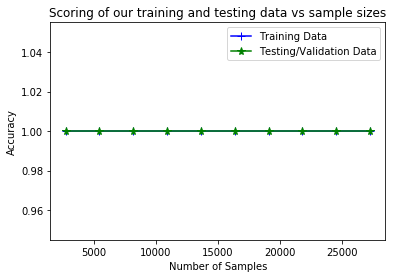

Code block 'learning_curve' took(HH:MM:SS): 0:00:43.343723
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.113517
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 4}
Grid Search Best score  0.974037039224653
Code block 'training' took(HH:MM:SS): 0:57:05.929366
Code block 'testing' took(HH:MM:SS): 0:02:57.010327
F1 score 0.9808686148915441
Classification report  
              precision    recall  f1-score   support

          1       0.99      1.00      0.99     10290
          2       0.96      0.93      0.95      1506
          3       0.97      0.90      0.93       845
          4       0.89      0.92      0.90       243
          5       0.98      0.64      0.77        96

avg / total       0.98      0.98      0.98     12980



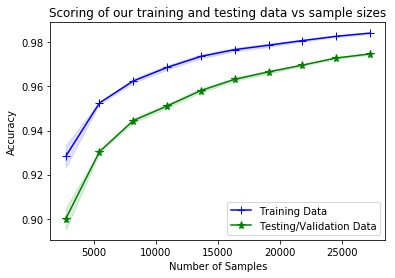

Code block 'learning_curve' took(HH:MM:SS): 2:35:44.890943
Code block 'predict_proba' took(HH:MM:SS): 0:01:22.574710
Code block 'overalltime' took(HH:MM:SS): 3:38:02.799394
13082799.393791825


In [20]:
timer = CodeTimer(name='overalltime')
model_metrics = {}

with timer:
    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])

        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 12)
        result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid , cv = cv,score = 'f1_weighted')

        _y_prediction = result['_y_prediction']

        _matrix = confusion_matrix(y_true = _y_test ,y_pred = _y_prediction, labels = _y_test['y'].values)

        model_metrics[model_name] = {}
        model_metrics[model_name]['confusion_matrix'] = _matrix
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
#         model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
        model_metrics[model_name]['f1_score'] = result['f1_score']
#         model_metrics[model_name]['roc_auc_score'] = result['roc_auc_score']
#         model_metrics[model_name]['roc_curve'] = result['roc_curve']
        model_metrics[model_name]['best_estimator'] = result['best_estimator']
        
        
print(timer.took)


In [23]:
decision_tree_model =model_metrics['decisiontreeclassifier']['best_estimator']

k_neighbor_model =model_metrics['kneighborsclassifier']['best_estimator']

#### At this point our models are ready using which we can predict on our test data. Note since we used  a pipeline, model has the built in scaling.

### Prepare the test data: category handling, date handling as done with train data. 


#### remember to check for column dimension

In [28]:
test_data = panda.read_csv(test_data_path)
test_data.shape

(18543, 8)

In [30]:
test_data.columns = [i.lower() for i in test_data.columns.tolist()]

In [31]:
test_data[['date-received']].isnull().sum()

date-received    0
dtype: int64

In [11]:
train_data['date-received'].value_counts()

1/19/2017     226
1/20/2017     175
4/26/2017     133
4/25/2017     125
9/8/2017      125
9/9/2017      113
1/24/2017     111
1/23/2017     110
7/18/2017     108
5/9/2017      106
5/17/2017     101
9/20/2016     100
1/25/2017     100
7/12/2017      97
5/23/2017      95
6/6/2017       95
2/15/2017      94
5/10/2017      94
7/17/2017      93
5/2/2017       91
1/26/2017      90
9/28/2016      90
5/16/2017      90
7/27/2017      89
4/24/2017      89
7/7/2017       89
4/28/2017      89
3/29/2017      89
8/4/2017       89
7/13/2017      89
             ... 
8/23/2017      10
9/2/2017       10
5/10/2015      10
8/6/2017       10
6/21/2015       9
8/25/2017       9
1/3/2016        9
9/4/2016        9
12/25/2016      8
9/11/2017       8
9/12/2017       8
9/24/2017       7
12/25/2015      7
11/3/2017       6
8/26/2017       6
9/4/2017        6
9/10/2017       5
9/3/2017        5
9/25/2017       5
9/20/2017       4
9/29/2017       4
9/19/2017       4
9/16/2017       3
8/27/2017       2
8/29/2017 

In [34]:
test_data['days_passed_since_complaint_received'] = test_data['date-received'].apply(lambda x : get_days_passed(x))

test_data[['days_passed_since_complaint_received']].head()

,days_passed_since_complaint_received
0,874
1,996
2,1022
3,562
4,971


In [36]:
## similarly for the data column complaint sent to company

test_data['days_since_complaint_sent_to_company'] = test_data['date-sent-to-company'].apply(lambda x : get_days_passed(x))

test_data[['days_since_complaint_sent_to_company']].head()

,days_since_complaint_sent_to_company
0,874
1,994
2,1022
3,562
4,971


In [37]:
test_data['transaction-type'].isnull().sum()


0

In [38]:
## transaction-type

le = LabelEncoder().fit(test_data['transaction-type'].values)

print(le.classes_)

transformed_transaction_types = le.transform(test_data['transaction-type'].values)


transformed = OneHotEncoder().fit_transform(transformed_transaction_types[:,np.newaxis])

print(transformed.toarray())

tt = panda.DataFrame(transformed.toarray())
tt.columns = le.classes_
tt

test_data_transaction_type_encoded = panda.concat([test_data,tt], axis =1)

test_data_transaction_type_encoded.head()

['Bank account or service' 'Checking or savings account' 'Consumer Loan'
 'Credit card' 'Credit card or prepaid card' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Money transfer, virtual currency, or money service'
 'Money transfers' 'Mortgage' 'Other financial service' 'Payday loan'
 'Payday loan, title loan, or personal loan' 'Prepaid card' 'Student loan'
 'Vehicle loan or lease' 'Virtual currency']
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,complaint-id,date-received,transaction-type,complaint-reason,company-response,date-sent-to-company,consumer-disputes,consumer-complaint-summary,days_passed_since_complaint_received,days_since_complaint_sent_to_company,...,"Money transfer, virtual currency, or money service",Money transfers,Mortgage,Other financial service,Payday loan,"Payday loan, title loan, or personal loan",Prepaid card,Student loan,Vehicle loan or lease,Virtual currency
0,Te-1,8/18/2016,Bank account or service,"Account opening, closing, or management",Company has responded to the consumer and the ...,8/18/2016,No,XXXX / XXXX / 16 I called Citibank to open a c...,874,874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Te-2,4/18/2016,Debt collection,Communication tactics,Company believes it acted appropriately as aut...,4/20/2016,No,I'm struggling financially. I called and I off...,996,994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Te-3,3/23/2016,Credit reporting,Incorrect information on credit report,NaN,3/23/2016,No,"In XXXX of 2015, an automatic payment was conf...",1022,1022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Te-4,6/26/2017,Student loan,Dealing with your lender or servicer,NaN,6/26/2017,NaN,"I submitted a request to XXXX, which is my cur...",562,562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Te-5,5/13/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,5/13/2016,No,A state tax lien was filed against me XXXX / X...,971,971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
del tt,le

In [ ]:
test_data_transaction_type_encoded['complaint-reason'].isnull().sum()


In [42]:

test_data_transaction_type_encoded['complaint-reason'].value_counts()
## geez total to 150 diff values

#### IMPORTANT:We will attempt to bin these values later.. since business acumen would be required in order to do so. By binning i mean, values like managing line of credit, incorrect line of credit, getting line of credit can be marked as LOC

le = LabelEncoder().fit(test_data_transaction_type_encoded['complaint-reason'].values)
transformed_values  = le.transform(test_data_transaction_type_encoded['complaint-reason'].values)

transformed = OneHotEncoder().fit_transform(transformed_values[:,np.newaxis])

tt = panda.DataFrame(transformed.toarray())
tt.columns = le.classes_

tt

test_data_two_encoded = panda.concat([test_data_transaction_type_encoded,tt],axis = 1)

test_data_two_encoded.head()

# del tt
# del le

,complaint-id,date-received,transaction-type,complaint-reason,company-response,date-sent-to-company,consumer-disputes,consumer-complaint-summary,days_passed_since_complaint_received,days_since_complaint_sent_to_company,...,Unable to get your credit report or credit score,Unauthorized transactions or other transaction problem,Unauthorized transactions/trans. issues,Unexpected or other fees,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Vehicle was repossessed or sold the vehicle,Written notification about debt,Wrong amount charged or received
0,Te-1,8/18/2016,Bank account or service,"Account opening, closing, or management",Company has responded to the consumer and the ...,8/18/2016,No,XXXX / XXXX / 16 I called Citibank to open a c...,874,874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Te-2,4/18/2016,Debt collection,Communication tactics,Company believes it acted appropriately as aut...,4/20/2016,No,I'm struggling financially. I called and I off...,996,994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Te-3,3/23/2016,Credit reporting,Incorrect information on credit report,NaN,3/23/2016,No,"In XXXX of 2015, an automatic payment was conf...",1022,1022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Te-4,6/26/2017,Student loan,Dealing with your lender or servicer,NaN,6/26/2017,NaN,"I submitted a request to XXXX, which is my cur...",562,562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Te-5,5/13/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,5/13/2016,No,A state tax lien was filed against me XXXX / X...,971,971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
del tt,le

In [44]:
test_data_two_encoded['company-response'].isnull().sum()

9701

In [52]:


## there are quite a few null values.. we will see what we can do about it.
## check the complaint status for the ones which has nan in company response
## if status is same throughout-- we can replace nan with some made up status
## else we will replace with the most appearing response

# test_data_two_encoded['company-response'].value_counts()

empty_response = train_data[train_data['Company-response'].isnull()][['Company-response','Complaint-Status']]

empty_response

most_appearing = empty_response['Complaint-Status'].value_counts().idxmax(axis=0)

most_appearing

'Closed with explanation'

In [53]:


test_data_two_encoded['company-response'].fillna(value = most_appearing, inplace=True)

test_data_two_encoded['company-response'].isnull().sum()



0

In [54]:
test_data_two_encoded['consumer-disputes'].isnull().sum()
## dere are close to 8k empty values..for now we will replace it will most appearing value


3304

In [55]:

most_appearing = test_data_two_encoded['consumer-disputes'].value_counts().idxmax(axis=1)


test_data_two_encoded['consumer-disputes'].fillna(value = most_appearing, inplace = True)

test_data_two_encoded['consumer-disputes'].isnull().sum()

test_data_two_encoded['encoded_consumer_disputes']= test_data_two_encoded['consumer-disputes'].apply(lambda x: 1 if x=='Yes' else 0)

test_data_two_encoded['encoded_consumer_disputes'].value_counts()

0    15128
1     3415
Name: encoded_consumer_disputes, dtype: int64

In [56]:
test_data_two_encoded.shape

(18543, 176)

In [57]:
#this is the target we used for training

target_dict = {
    
    'Closed with explanation':1,
    'Closed with non-monetary relief':2,
    'Closed with monetary relief':3,
    'Closed':4,
    'Untimely response':5
    
}

In [58]:
test_data_two_encoded.head()

,complaint-id,date-received,transaction-type,complaint-reason,company-response,date-sent-to-company,consumer-disputes,consumer-complaint-summary,days_passed_since_complaint_received,days_since_complaint_sent_to_company,...,Unauthorized transactions or other transaction problem,Unauthorized transactions/trans. issues,Unexpected or other fees,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Vehicle was repossessed or sold the vehicle,Written notification about debt,Wrong amount charged or received,encoded_consumer_disputes
0,Te-1,8/18/2016,Bank account or service,"Account opening, closing, or management",Company has responded to the consumer and the ...,8/18/2016,No,XXXX / XXXX / 16 I called Citibank to open a c...,874,874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Te-2,4/18/2016,Debt collection,Communication tactics,Company believes it acted appropriately as aut...,4/20/2016,No,I'm struggling financially. I called and I off...,996,994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,Te-3,3/23/2016,Credit reporting,Incorrect information on credit report,Closed with explanation,3/23/2016,No,"In XXXX of 2015, an automatic payment was conf...",1022,1022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Te-4,6/26/2017,Student loan,Dealing with your lender or servicer,Closed with explanation,6/26/2017,No,"I submitted a request to XXXX, which is my cur...",562,562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,Te-5,5/13/2016,Credit reporting,Incorrect information on credit report,Company has responded to the consumer and the ...,5/13/2016,No,A state tax lien was filed against me XXXX / X...,971,971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [59]:
columns_not_required = ['complaint-id',\
 'date-received',\
 'transaction-type',\
 'complaint-reason',\
 'company-response',\
 'date-sent-to-company',\
 'complaint-status',\
 'consumer-disputes',\
 'consumer-complaint-summary']


test_x = test_data_two_encoded[[i for i in test_data_two_encoded.columns.tolist() if i not in columns_not_required]]
test_x.shape

(18543, 168)

### our columns are not matching.. train_X has 176 column. test_x has only 168. somethings amiss!!!!

In [62]:
len(train_data['Transaction-Type'].value_counts()) == len(test_data['transaction-type'].value_counts())

True

In [65]:
len(train_data['Complaint-reason'].value_counts()) == len(test_data['complaint-reason'].value_counts())

## this is the problem.. number of unique variables in complaint reason in train and test set differs..so
## when we perform one hot encoding it actually causes issues

False

In [64]:
len(train_data['Consumer-disputes'].value_counts()) == len(test_data['consumer-disputes'].value_counts())

True

In [87]:
len(train_data['Company-response'].value_counts()) == len(test_data['company-response'].value_counts())

True

In [66]:
print(len(train_data['Complaint-reason'].value_counts()),len(test_data['complaint-reason'].value_counts()))

150 147


In [77]:

set(train_data['Complaint-reason'].values.tolist())-set(test_data['complaint-reason'].values.tolist())
## there are a total of 5 differences..categories present in train but not present in test

{'Account terms and changes',
 'Advertising',
 'Incorrect exchange rate',
 'Problem with an overdraft',
 "Was approved for a loan, but didn't receive the money"}

In [78]:

set(test_data['complaint-reason'].values.tolist())-set(train_data['Complaint-reason'].values.tolist())

{"Can't stop withdrawals from your bank account", 'Problem with cash advance'}

In [89]:
## lets check and see if maybe spelling mistakes are present..eg account terms&changes in test set but account terms and changes in train

set([i for i in test_data['complaint-reason'].values.tolist() if i.lower().startswith('account')]),\
set([i for i in test_data['complaint-reason'].values.tolist() if i.lower().startswith('adv')]),\
set([i for i in test_data['complaint-reason'].values.tolist() if i.lower().startswith('incor')]),\
set([i for i in test_data['complaint-reason'].values.tolist() if i.lower().startswith('problem')]),\
set([i for i in test_data['complaint-reason'].values.tolist() if 'loan' in i.lower()])

({'Account opening, closing, or management'},
 {'Advertising and marketing',
  'Advertising and marketing, including promotional offers',
  'Advertising, marketing or disclosures'},
 {'Incorrect information on credit report',
  'Incorrect information on your report',
  'Incorrect/missing disclosures or info'},
 {'Problem adding money',
  'Problem caused by your funds being low',
  'Problem getting a card or closing an account',
  'Problem when making payments',
  "Problem with a company's investigation into an existing issue",
  "Problem with a credit reporting company's investigation into an existing problem",
  'Problem with a lender or other company charging your account',
  'Problem with a purchase or transfer',
  'Problem with a purchase shown on your statement',
  'Problem with additional add-on products or services',
  'Problem with cash advance',
  'Problem with customer service',
  'Problem with fraud alerts or security freezes',
  'Problem with the payoff process at the end o

#### "Can't stop withdrawals from your bank account", 'Problem with cash advance 
-- these values are present in test set and not present in train data. We cannot predict for values which we have not trained in. which means we can safely drop these values from the training as well as test data

### we may have to apply proper bining and categorization on complaint reason category field